In [158]:
import pandas as pd
import numpy as np
import warnings
import os
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox, normaltest, shapiro
import statsmodels.api as sm
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid
import statsmodels
import functions_ts
import importlib
from datetime import date, time, datetime

importlib.reload(functions_ts)

<module 'functions_ts' from '/home/jsancheg/git_environment/Europe_Cancer_Incidence/src/data/functions_ts.py'>

In [159]:
# Obtener el directorio del script

script_dir = Path.cwd()
project_root = script_dir.parent.parent
print(script_dir)
print(project_root)

file_path = project_root/ 'data' / 'processed' / 'EQUIPO5.csv'
print(file_path)

df_aux1 = pd.read_csv(file_path)
print(df_aux1.head())
print(df_aux1.info())
print(df_aux1.describe())



/home/jsancheg/git_environment/Europe_Cancer_Incidence/src/data
/home/jsancheg/git_environment/Europe_Cancer_Incidence
/home/jsancheg/git_environment/Europe_Cancer_Incidence/data/processed/EQUIPO5.csv
           ds   y
0  02/01/2024  27
1  03/01/2024  29
2  04/01/2024  26
3  05/01/2024  25
4  08/01/2024  20
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      466 non-null    object
 1   y       466 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.4+ KB
None
                y
count  466.000000
mean    31.828326
std      9.345261
min      2.000000
25%     25.000000
50%     31.500000
75%     39.000000
max     65.000000


In [177]:
df_aux1['date_string'] = df_aux1['ds'].astype(str)
df_aux1.head(10)
format_string = "%d/%m/%Y"
df_aux1['date_format'] = pd.to_datetime(df_aux1['date_string'], format = format_string, errors = 'coerce')
min_date = df_aux1['date_format'].min()
max_date = df_aux1['date_format'].max()
print(f"Fecha de inicio: {min_date}")
print(f"Fecha de inicio: {max_date}")

df_aux2 = pd.DataFrame( { 'ds': list(pd.date_range(start = min_date, end = max_date, freq = 'D') ) } )
print(type(df_aux2)) 
print(df_aux2.head(5))
aux = pd.merge(df_aux2, df_aux1, left_on = 'ds', right_on = 'date_format', how = 'outer')
aux['missing_values'] = aux['ds_y'].isna().astype(int)
aux['dsx_y'] = aux['ds_x'].fillna(0)
aux['y'] = aux['y'].fillna(0)
aux = aux.rename(columns = {'missing_values' : 'fin_de_semana'})
print(aux)

Fecha de inicio: 2024-01-02 00:00:00
Fecha de inicio: 2025-11-19 00:00:00
<class 'pandas.core.frame.DataFrame'>
          ds
0 2024-01-02
1 2024-01-03
2 2024-01-04
3 2024-01-05
4 2024-01-06
          ds_x        ds_y     y date_string date_format  fin_de_semana  \
0   2024-01-02  02/01/2024  27.0  02/01/2024  2024-01-02              0   
1   2024-01-03  03/01/2024  29.0  03/01/2024  2024-01-03              0   
2   2024-01-04  04/01/2024  26.0  04/01/2024  2024-01-04              0   
3   2024-01-05  05/01/2024  25.0  05/01/2024  2024-01-05              0   
4   2024-01-06         NaN   0.0         NaN         NaT              1   
..         ...         ...   ...         ...         ...            ...   
683 2025-11-15         NaN   0.0         NaN         NaT              1   
684 2025-11-16         NaN   0.0         NaN         NaT              1   
685 2025-11-17  17/11/2025  40.0  17/11/2025  2025-11-17              0   
686 2025-11-18  18/11/2025  38.0  18/11/2025  2025-11-18    

In [162]:
serie_df = aux[['ds_x', 'y']]
serie_df = serie_df.rename(columns = {'ds_x': 'ds'})
print(serie_df.head(10))
print(serie_df.shape)

          ds     y
0 2024-01-02  27.0
1 2024-01-03  29.0
2 2024-01-04  26.0
3 2024-01-05  25.0
4 2024-01-06   0.0
5 2024-01-07   0.0
6 2024-01-08  20.0
7 2024-01-09  13.0
8 2024-01-10  17.0
9 2024-01-11  26.0
(688, 2)


<Figure size 1000x400 with 0 Axes>

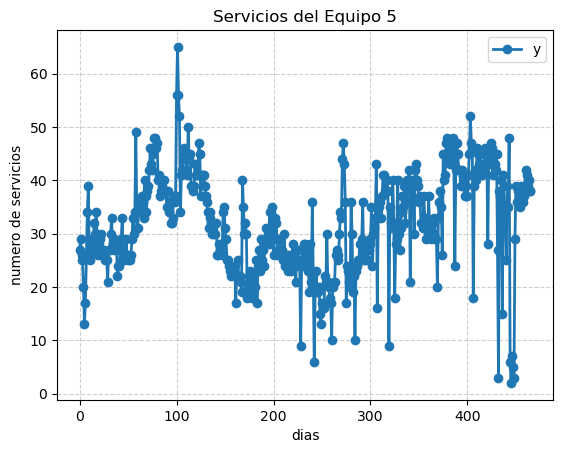

In [120]:
functions_ts.plot_serie(df_aux1[['ds','y']], "Servicios del Equipo 5", "dias", "numero de servicios")

In [166]:
modelo1 = Prophet(
    growth = 'linear',
    yearly_seasonality = True,
    weekly_seasonality = True,
    daily_seasonality = True,
    seasonality_mode = 'additive',
    changepoint_prior_scale = 0.05,
    seasonality_prior_scale = 10.0,
    interval_width = 0.95,
    uncertainty_samples = 1000
)


modelo1.fit(serie_df)
    

20:11:34 - cmdstanpy - INFO - Chain [1] start processing
20:11:34 - cmdstanpy - INFO - Chain [1] done processing


In [167]:
future1 = modelo1.make_future_dataframe(
    periods = 30,
    freq = 'D'
)

print("\nGenerating predictions...")
forecast1 = modelo1.predict(future1)


Generating predictions...


In [169]:
future1_forecast = forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30).copy()
print("\n30 dias forecast")
print(future1_forecast)


30 dias forecast
            ds       yhat  yhat_lower  yhat_upper
688 2025-11-20  34.172567   17.925737   51.541261
689 2025-11-21  29.061294   12.782985   45.576331
690 2025-11-22   3.111762  -13.061400   19.607320
691 2025-11-23   3.172118  -12.015655   19.529891
692 2025-11-24  32.741774   16.187422   48.947435
693 2025-11-25  35.303801   18.441496   51.872589
694 2025-11-26  35.344397   18.134496   51.772213
695 2025-11-27  34.613235   17.088654   50.961702
696 2025-11-28  29.408100   11.357105   46.596547
697 2025-11-29   3.357699  -12.796987   19.855658
698 2025-11-30   3.309462  -13.687542   19.362955
699 2025-12-01  32.762217   17.324783   49.347861
700 2025-12-02  35.198630   19.638577   52.093614
701 2025-12-03  35.104710   18.249433   51.788772
702 2025-12-04  34.230199   16.535741   50.478107
703 2025-12-05  28.873238   13.000231   46.579585
704 2025-12-06   2.663198  -14.875367   18.625148
705 2025-12-07   2.448504  -13.483272   16.962465
706 2025-12-08  31.729310   13.8

In [173]:
future1_forecast['prediction_interval'] = future1_forecast['yhat_upper'] - future1_forecast['yhat_lower']
future1_forecast['relative_uncertainty'] = np.where(
    future1_forecast['yhat'] != 0,
    (future1_forecast['yhat_upper'] - future1_forecast['yhat_lower'])/ future1_forecast['yhat'] * 100,
    np.nan
)
print("\nForecast with uncertainty metrics")
future1_forecast_display = future1_forecast.copy()
future1_forecast_display['yhat'] = future1_forecast['yhat'].round(0)
future1_forecast_display['yhat'] = future1_forecast['yhat_lower'].round(0)
future1_forecast_display['yhat_upper'] = future1_forecast['yhat_upper'].round(0)
future1_forecast_display['prediction_interval'] = future1_forecast['prediction_interval'].round(0)
future1_forecast_display['relative_uncertainty'] = future1_forecast['relative_uncertainty'].round(0)

print(future1_forecast_display)



Forecast with uncertainty metrics
            ds  yhat  yhat_lower  yhat_upper  prediction_interval  \
688 2025-11-20  18.0   17.925737        52.0                 34.0   
689 2025-11-21  13.0   12.782985        46.0                 33.0   
690 2025-11-22 -13.0  -13.061400        20.0                 33.0   
691 2025-11-23 -12.0  -12.015655        20.0                 32.0   
692 2025-11-24  16.0   16.187422        49.0                 33.0   
693 2025-11-25  18.0   18.441496        52.0                 33.0   
694 2025-11-26  18.0   18.134496        52.0                 34.0   
695 2025-11-27  17.0   17.088654        51.0                 34.0   
696 2025-11-28  11.0   11.357105        47.0                 35.0   
697 2025-11-29 -13.0  -12.796987        20.0                 33.0   
698 2025-11-30 -14.0  -13.687542        19.0                 33.0   
699 2025-12-01  17.0   17.324783        49.0                 32.0   
700 2025-12-02  20.0   19.638577        52.0                 32.0   

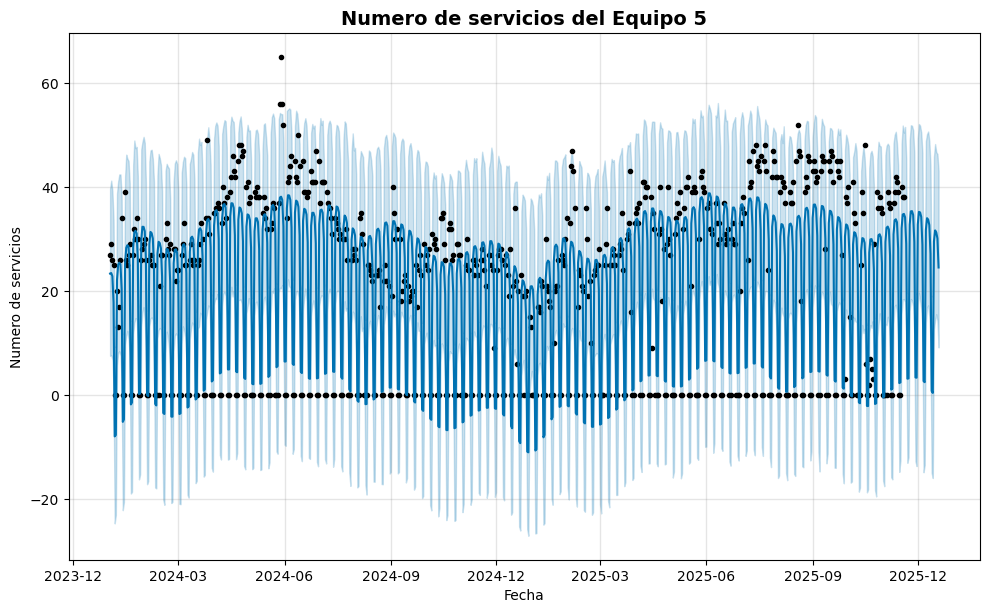

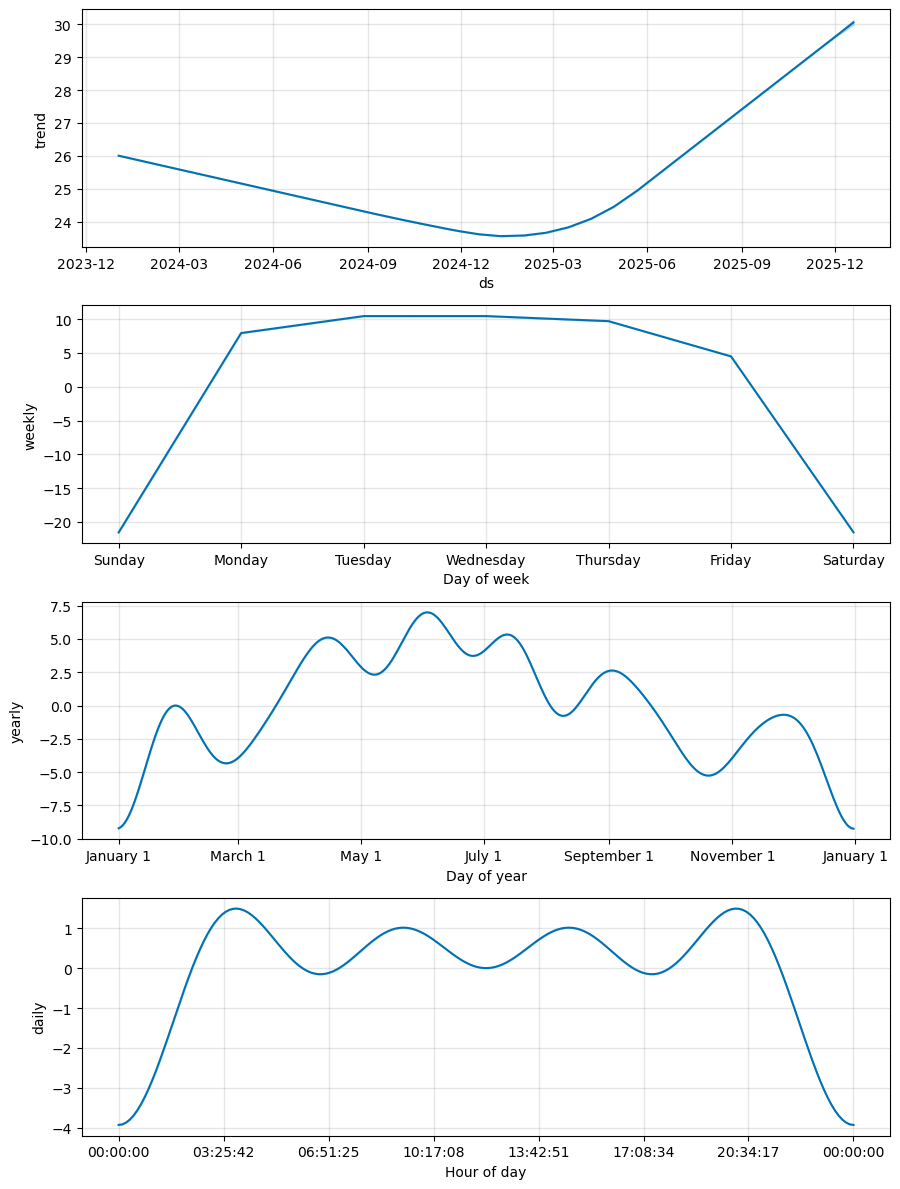

In [172]:
warnings.filterwarnings(
    'ignore',
    message = "The behavior of DatetimeProperties.to_pydatetime is deprecated",
    category = FutureWarning
)

fig1 = modelo1.plot(forecast1)
fig1.gca().set_title("Numero de servicios del Equipo 5", fontsize = 14, fontweight = 'bold')
fig1.gca().set_xlabel('Fecha')
fig1.gca().set_ylabel('Numero de servicios')
plt.show()

fig2 = modelo1.plot_components(forecast1)
plt.show()

In [174]:
# Busqueda de parametros
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale':[10.0, 20.0]
}

parametros = list(ParameterGrid(param_grid))
print(f"\n...2. Probando {len(parametros)} combinaciones de parametros ---")

# Validacion cruzada
initial_train = '180 days'
cutoffs_period = '30 days'
forecast_horizon = '30 days'

resultados1_tuning = []

for params in parametros:
    print(f"\n --- Evaluando parametros: {params} ---")

    m1 = Prophet(
        growth = 'linear',
        yearly_seasonality = True,
        weekly_seasonality = True,
        daily_seasonality = True,
        changepoint_prior_scale = params['changepoint_prior_scale'],
        seasonality_prior_scale = params['seasonality_prior_scale']
    )

    m1.fit(serie_df)

    df1_cv = cross_validation(
        model = m1,
        initial = initial_train,
        period = cutoffs_period,
        horizon = forecast_horizon,
    )

    df1_metrics = performance_metrics(df1_cv, metrics=['mae'], rolling_window = 1)

    if df1_metrics is not None and not df1_metrics.empty:
        mae_promedio = df1_metrics['mae'].mean()
    else:
        print(f"WARNING: Metrics failed for {params}. Setting MAE to NaN.")
        mae_promedio = np.nan

    resultados1_tuning.append({
        'parametros': params,
        'mae_promedio': mae_promedio
    })

    print(f"MAE Promedio: {mae_promedio:.4f}") 

    

20:30:23 - cmdstanpy - INFO - Chain [1] start processing
20:30:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



...2. Probando 8 combinaciones de parametros ---

 --- Evaluando parametros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0} ---


  0%|          | 0/16 [00:00<?, ?it/s]20:30:23 - cmdstanpy - INFO - Chain [1] start processing
20:30:23 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:00<00:02,  6.47it/s]20:30:23 - cmdstanpy - INFO - Chain [1] start processing
20:30:23 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:00<00:02,  6.72it/s]20:30:23 - cmdstanpy - INFO - Chain [1] start processing
20:30:23 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:00<00:01,  6.73it/s]20:30:23 - cmdstanpy - INFO - Chain [1] start processing
20:30:23 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:00<00:01,  6.55it/s]20:30:23 - cmdstanpy - INFO - Chain [1] start processing
20:30:24 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:00<00:01,  6.25it/s]20:30:24 - cmdstanpy - INFO - Chain [1] start processing
20:30:24 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 6/16 [00:00<00:01,  6.09it/s]20:30:24

MAPE Promedio: 8.3131

 --- Evaluando parametros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0} ---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/16 [00:00<?, ?it/s]20:30:26 - cmdstanpy - INFO - Chain [1] start processing
20:30:26 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:00<00:02,  6.42it/s]20:30:26 - cmdstanpy - INFO - Chain [1] start processing
20:30:27 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:00<00:02,  6.60it/s]20:30:27 - cmdstanpy - INFO - Chain [1] start processing
20:30:27 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:00<00:02,  6.43it/s]20:30:27 - cmdstanpy - INFO - Chain [1] start processing
20:30:27 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:00<00:01,  6.37it/s]20:30:27 - cmdstanpy - INFO - Chain [1] start processing
20:30:27 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:00<00:01,  6.21it/s]20:30:27 - cmdstanpy - INFO - Chain [1] start processing
20:30:

MAPE Promedio: 8.3533

 --- Evaluando parametros: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0} ---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/16 [00:00<?, ?it/s]20:30:30 - cmdstanpy - INFO - Chain [1] start processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:00<00:02,  5.67it/s]20:30:30 - cmdstanpy - INFO - Chain [1] start processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:00<00:02,  5.79it/s]20:30:30 - cmdstanpy - INFO - Chain [1] start processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:00<00:02,  5.41it/s]20:30:30 - cmdstanpy - INFO - Chain [1] start processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:00<00:02,  5.61it/s]20:30:30 - cmdstanpy - INFO - Chain [1] start processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:00<00:01,  5.60it/s]20:30:31 - cmdstanpy - INFO - Chain [1] start processing
20:30:

MAPE Promedio: 8.1539

 --- Evaluando parametros: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0} ---


  0%|          | 0/16 [00:00<?, ?it/s]20:30:33 - cmdstanpy - INFO - Chain [1] start processing
20:30:33 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:00<00:02,  6.03it/s]20:30:33 - cmdstanpy - INFO - Chain [1] start processing
20:30:33 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:00<00:02,  6.17it/s]20:30:33 - cmdstanpy - INFO - Chain [1] start processing
20:30:34 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:00<00:02,  6.25it/s]20:30:34 - cmdstanpy - INFO - Chain [1] start processing
20:30:34 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:00<00:01,  6.32it/s]20:30:34 - cmdstanpy - INFO - Chain [1] start processing
20:30:34 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:00<00:01,  6.32it/s]20:30:34 - cmdstanpy - INFO - Chain [1] start processing
20:30:34 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 6/16 [00:00<00:01,  6.23it/s]20:30:34

MAPE Promedio: 8.1803

 --- Evaluando parametros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0} ---


  0%|          | 0/16 [00:00<?, ?it/s]20:30:37 - cmdstanpy - INFO - Chain [1] start processing
20:30:37 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:00<00:01,  7.54it/s]20:30:37 - cmdstanpy - INFO - Chain [1] start processing
20:30:37 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:00<00:02,  6.96it/s]20:30:37 - cmdstanpy - INFO - Chain [1] start processing
20:30:37 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:00<00:01,  6.86it/s]20:30:37 - cmdstanpy - INFO - Chain [1] start processing
20:30:37 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:00<00:01,  6.80it/s]20:30:37 - cmdstanpy - INFO - Chain [1] start processing
20:30:37 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:00<00:01,  6.52it/s]20:30:37 - cmdstanpy - INFO - Chain [1] start processing
20:30:37 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 6/16 [00:00<00:01,  6.36it/s]20:30:38

MAPE Promedio: 9.9110

 --- Evaluando parametros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0} ---


  0%|          | 0/16 [00:00<?, ?it/s]20:30:40 - cmdstanpy - INFO - Chain [1] start processing
20:30:40 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:00<00:02,  7.24it/s]20:30:40 - cmdstanpy - INFO - Chain [1] start processing
20:30:40 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:00<00:02,  6.92it/s]20:30:40 - cmdstanpy - INFO - Chain [1] start processing
20:30:40 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:00<00:01,  7.20it/s]20:30:40 - cmdstanpy - INFO - Chain [1] start processing
20:30:40 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:00<00:01,  7.19it/s]20:30:40 - cmdstanpy - INFO - Chain [1] start processing
20:30:40 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:00<00:01,  6.66it/s]20:30:41 - cmdstanpy - INFO - Chain [1] start processing
20:30:41 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 6/16 [00:00<00:01,  6.58it/s]20:30:41

MAPE Promedio: 9.9427

 --- Evaluando parametros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0} ---


20:30:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/16 [00:00<?, ?it/s]20:30:43 - cmdstanpy - INFO - Chain [1] start processing
20:30:43 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:00<00:02,  7.15it/s]20:30:43 - cmdstanpy - INFO - Chain [1] start processing
20:30:43 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:00<00:02,  6.96it/s]20:30:44 - cmdstanpy - INFO - Chain [1] start processing
20:30:44 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:00<00:01,  6.59it/s]20:30:44 - cmdstanpy - INFO - Chain [1] start processing
20:30:44 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:00<00:02,  5.99it/s]20:30:44 - cmdstanpy - INFO - Chain [1] start processing
20:30:44 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:00<00:01,  6.14it/s]20:30:4

MAPE Promedio: 21.4573

 --- Evaluando parametros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0} ---


20:30:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/16 [00:00<?, ?it/s]20:30:47 - cmdstanpy - INFO - Chain [1] start processing
20:30:47 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:00<00:02,  6.52it/s]20:30:47 - cmdstanpy - INFO - Chain [1] start processing
20:30:48 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:00<00:02,  6.56it/s]20:30:48 - cmdstanpy - INFO - Chain [1] start processing
20:30:48 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:00<00:02,  6.36it/s]20:30:48 - cmdstanpy - INFO - Chain [1] start processing
20:30:48 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:00<00:02,  5.95it/s]20:30:48 - cmdstanpy - INFO - Chain [1] start processing
20:30:48 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:00<00:01,  6.03it/s]20:30:4

MAPE Promedio: 22.1032


In [157]:
resultados1_df = pd.DataFrame(resultados1_tuning)

# Ordernar por MAPE para encontrar el mejor resultado (el valor más bajo)
mejor_modelo1 = resultados1_df.sort_values(by = 'mae_promedio').iloc[0]

print("\n\n--- 4. Resumen de Resultados del Tuning (Ordenado por MAE) ---")
print(resultados1_df.sort_values(by='mae_promedio'))

print("\n--- ¡MEJOR CONFIGURACIÓN ENCONTRADA! ---")
print(f"Mejor 'changepoint_prior_scale': {mejor_modelo1['parametros']['changepoint_prior_scale']}")
print(f"Mejor 'seasonality_prior_scale': {mejor_modelo1['parametros']['seasonality_prior_scale']}")
print(f"MAPE Mínimo Obtenido: {mejor_modelo1['mae_promedio']:.4f}")



--- 4. Resumen de Resultados del Tuning (Ordenado por MAE) ---
                                          parametros  mae_promedio
0  {'changepoint_prior_scale': 0.01, 'seasonality...     14.685718
1  {'changepoint_prior_scale': 0.01, 'seasonality...     14.685718
6  {'changepoint_prior_scale': 0.5, 'seasonality_...     14.701624
7  {'changepoint_prior_scale': 0.5, 'seasonality_...     14.701624
2  {'changepoint_prior_scale': 0.05, 'seasonality...     14.960827
3  {'changepoint_prior_scale': 0.05, 'seasonality...     14.960827
4  {'changepoint_prior_scale': 0.1, 'seasonality_...     15.004379
5  {'changepoint_prior_scale': 0.1, 'seasonality_...     15.004379

--- ¡MEJOR CONFIGURACIÓN ENCONTRADA! ---
Mejor 'changepoint_prior_scale': 0.01
Mejor 'seasonality_prior_scale': 10.0
MAPE Mínimo Obtenido: 14.6857


In [137]:
# Including an extra regresor

In [183]:
serie_df_a = aux[['ds_x', 'y', 'fin_de_semana']]
serie_df_a = serie_df_a.rename(columns = {'ds_x': 'ds'})




modelo2 = Prophet(
    growth = 'linear',
    yearly_seasonality = True,
    weekly_seasonality = False,
    daily_seasonality = True,
    seasonality_mode = 'additive',
    changepoint_prior_scale = 0.01,
    seasonality_prior_scale = 10.0,
    interval_width = 0.95,
    uncertainty_samples = 1000
)


modelo2.add_regressor('fin_de_semana')
    
modelo2.fit(serie_df_a)
    


20:48:05 - cmdstanpy - INFO - Chain [1] start processing
20:48:05 - cmdstanpy - INFO - Chain [1] done processing


In [184]:
future2 = modelo2.make_future_dataframe(
    periods = 30,
    freq = 'D'
)



In [185]:
print("\nGenerating predictions...")
forecast2 = modelo2.predict(future2)


Generating predictions...


ValueError: Regressor 'fin_de_semana' missing from dataframe